# Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import zipfile
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Dropout,SpatialDropout1D,BatchNormalization
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import nltk
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Check if WordNet is available, if not, download it and extract
try:
    nltk.data.find('corpora/wordnet.zip')
except LookupError:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    with zipfile.ZipFile('/kaggle/working/corpora/wordnet.zip', 'r') as zip_ref:
        zip_ref.extractall('/kaggle/working/corpora')
    nltk.data.path.append('/kaggle/working/')

# Now you can import wordnet from nltk.corpus
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...


# Text Preprocessing

In [ ]:
# Define preprocessing function
def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [ ]:
# Function to read files from folder and create DataFrame
def create_dataframe(folder, label):
    file_list = os.listdir(folder)
    texts = []
    labels = []
    for file in file_list:
        with open(os.path.join(folder, file), 'r', encoding='utf-8') as f:
            text = f.read()
            texts.append(preprocess_text(text))
            labels.append(label)
    df = pd.DataFrame({'text': texts, 'label': labels})
    return df

In [ ]:
# # Paths to positive and negative folders for training
# positive_folder_train = 'path/to/positive/folder/train'
# negative_folder_train = 'path/to/negative/folder/train'

# # Paths to positive and negative folders for testing
# positive_folder_test = 'path/to/positive/folder/test'
# negative_folder_test = 'path/to/negative/folder/test'
# Paths to positive and negative folders
positive_folder_train = '/kaggle/input/imdb-nlp/aclImdb/train/pos'

negative_folder_train = '/kaggle/input/imdb-nlp/aclImdb/train/neg'


# Paths to positive and negative folders
positive_folder_test = '/kaggle/input/imdb-nlp/aclImdb/test/pos'

negative_folder_test = '/kaggle/input/imdb-nlp/aclImdb/test/neg'

In [ ]:
# Create DataFrames for positive and negative reviews
df_train_positive = create_dataframe(positive_folder_train, 1)  # Label 1 for positive
df_train_negative = create_dataframe(negative_folder_train, 0)  # Label 0 for negative
df_test_positive = create_dataframe(positive_folder_test, 1)  # Label 1 for positive
df_test_negative = create_dataframe(negative_folder_test, 0)  # Label 0 for negative

In [ ]:
# Combine positive and negative DataFrames for train and test
df_train = pd.concat([df_train_positive, df_train_negative], ignore_index=True)
df_test = pd.concat([df_test_positive, df_test_negative], ignore_index=True)

# Combine train and test data, then split into training and validation sets
df_combined = pd.concat([df_train, df_test], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)  # Shuffle the combined data

In [ ]:
df_combined.to_csv('imdb.csv', index=False)

# Tokenization

In [ ]:
# Tokenize text
max_words = 10000  # Maximum number of words to keep
max_len = 100      # Maximum length of each sequence
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_combined['text'])
X = tokenizer.texts_to_sequences(df_combined['text'])
X = pad_sequences(X, maxlen=max_len)

# Prepare target
y = np.array(df_combined['label'])

# Splitting data

In [ ]:
# Splitting data into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model




In [ ]:
# # Build LSTM model
# lstm_model = Sequential([
#     Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
#     LSTM(64, dropout=0.2, recurrent_dropout=0.2),
#     Dense(1, activation='sigmoid')
# ])
# Define the model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
lstm_model.add(SpatialDropout1D(0.5))
lstm_model.add(LSTM(5, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(BatchNormalization())


lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train LSTM model
history =lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7276 - loss: 0.5259 - val_accuracy: 0.8737 - val_loss: 0.3041
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8799 - loss: 0.3107 - val_accuracy: 0.8768 - val_loss: 0.3060
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9022 - loss: 0.2576 - val_accuracy: 0.8711 - val_loss: 0.3206
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9103 - loss: 0.2343 - val_accuracy: 0.8761 - val_loss: 0.3206
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9237 - loss: 0.2044 - val_accuracy: 0.8730 - val_loss: 0.3647
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9247 - loss: 0.1983 - val_accuracy: 0.8692 - val_loss: 0.3897
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9289 - loss: 0.1832 - val_accuracy: 0.8622 - val_loss: 0.4463
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9343 - loss: 0.1692 -

In [ ]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (32, 100, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 5)                     │           2,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 5)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 5)                     │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1)                     │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,848,100 (14.68 MB)

 Trainable params: 1,282,696 (4.89 MB)

 Non-trainable params: 10 (40.00 B)

 Optimizer params: 2,565,394 (9.79 MB)

# Plot training & validation accuracy values

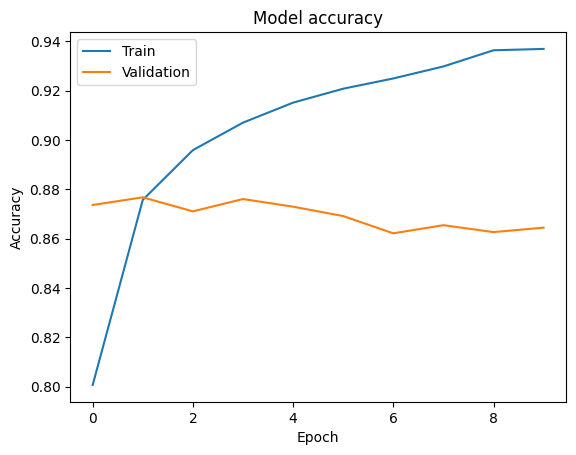

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate LSTM model
y_pred_lstm = (lstm_model.predict(X_val) > 0.5).astype('int32')
print("\nLSTM Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred_lstm))
print("Classification Report:")
print(classification_report(y_val, y_pred_lstm))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

LSTM Model Evaluation:
Accuracy: 0.8645
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4978
           1       0.85      0.89      0.87      5022

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



# Build LSTM model




In [ ]:
# Build GRU model
gru_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    GRU(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define the model
GRU_model = Sequential()
GRU_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
GRU_model.add(SpatialDropout1D(0.5))
GRU_model.add(GRU(5, return_sequences=False))
GRU_model.add(Dropout(0.5))
GRU_model.add(BatchNormalization())
GRU_model.add(Dense(1, activation='sigmoid'))

In [ ]:
GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# # Train GRU model
gru_history=GRU_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10,batch_size=32)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6981 - loss: 0.5709 - val_accuracy: 0.8670 - val_loss: 0.3171
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8815 - loss: 0.3112 - val_accuracy: 0.8808 - val_loss: 0.2887
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8965 - loss: 0.2678 - val_accuracy: 0.8771 - val_loss: 0.3003
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9111 - loss: 0.2396 - val_accuracy: 0.8702 - val_loss: 0.3242
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9178 - loss: 0.2200 - val_accuracy: 0.8708 - val_loss: 0.3519
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9236 - loss: 0.2046 - val_accuracy: 0.8683 - val_loss: 0.3670
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9274 - loss: 0.1898 - val_accuracy: 0.8720 - val_loss: 0.3754
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9299 - loss: 0.1822 -

In [ ]:
GRU_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (32, 100, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (32, 100, 128)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (32, 5)                     │           2,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 5)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (32, 5)                     │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 1)                     │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,846,135 (14.67 MB)

 Trainable params: 1,282,041 (4.89 MB)

 Non-trainable params: 10 (40.00 B)

 Optimizer params: 2,564,084 (9.78 MB)

# Plot training & validation accuracy values

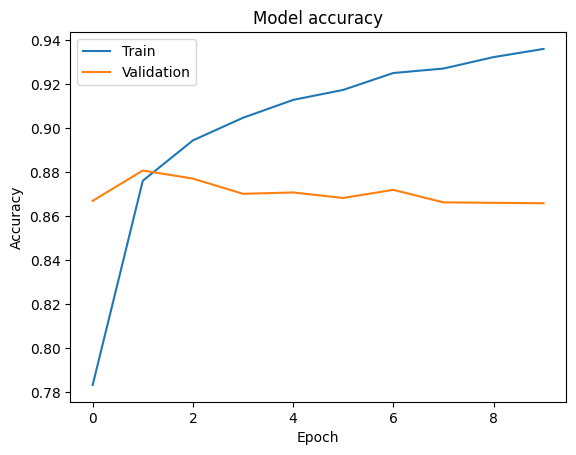

In [ ]:
# Plot training & validation accuracy values
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate GRU model
y_pred = (GRU_model.predict(X_val) > 0.5).astype('int32')
print("\nGRU Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

GRU Model Evaluation:
Accuracy: 0.8659
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4978
           1       0.86      0.88      0.87      5022

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

